In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import datetime

#Load datasets
report = pd.read_csv('/Users/Guanguan/Desktop/ML/data/report.csv')
birth = pd.read_csv('/Users/Guanguan/Desktop/ML/data/birth.csv')
breed = pd.read_csv('/Users/Guanguan/Desktop/ML/data/breed.csv')
spec = pd.read_csv('/Users/Guanguan/Desktop/ML/data/spec.csv')
submission = pd.read_csv('/Users/Guanguan/Desktop/ML/data/submission.csv')

#Rename columns
report.columns = ['ID','Year','Month','FarmCode','CowNo','FatherSemenNo','MotherNo','BirthDate','Parity',
                  'DaysOfLactation','MilkYield','LatestCalvingDate','SampleDate','AgeInMonths','TestingDate',
                  'LastBreedingDate','LastBreedingSemen','NumberOfBreeding','PreviousCalvingDate',
                  'FirstBreedingDate','FirstBreedingSemen']
birth.columns = ['CowNo','CalvingDate','DryDate','CalfNo1','CalfNo2','MotherWeight','RecordingDate',
                 'IfParityRecorded','Parity','HardnessOfCalving','CalfSize','CalfGender','FarmCode']
breed.columns = ['CowNo','BreedingDate','BreedingSemen','RecordingDate','PregnancyTest','BreedingMethod',
                 'SemenType','FarmCode']
spec.columns = ['CowNo','SituationType','SituationCode','SituationDate','Remarks','RecordingDate','FarmCode']

/Users/Guanguan/opt/anaconda3/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
report.head()

,ID,Year,Month,FarmCode,CowNo,FatherSemenNo,MotherNo,BirthDate,Parity,DaysOfLactation,...,LatestCalvingDate,SampleDate,AgeInMonths,TestingDate,LastBreedingDate,LastBreedingSemen,NumberOfBreeding,PreviousCalvingDate,FirstBreedingDate,FirstBreedingSemen
0,1,2013,3,A,52612,507H7173,96040545,2011/1/1 00:00,1,78.0,...,2013/1/1 00:00,2013/3/20 00:00,26,2013/3/21 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784
1,2,2013,4,A,52612,507H7173,96040545,2011/1/1 00:00,1,107.0,...,2013/1/1 00:00,2013/4/18 00:00,27,2013/4/19 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784
2,3,2013,5,A,52612,507H7173,96040545,2011/1/1 00:00,1,140.0,...,2013/1/1 00:00,2013/5/21 00:00,28,2013/5/22 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784
3,4,2013,6,A,52612,507H7173,96040545,2011/1/1 00:00,1,175.0,...,2013/1/1 00:00,2013/6/25 00:00,29,2013/6/26 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784
4,5,2013,7,A,52612,507H7173,96040545,2011/1/1 00:00,1,210.0,...,2013/1/1 00:00,2013/7/30 00:00,30,2013/7/31 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784


In [3]:
report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37517 entries, 0 to 37516
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   37517 non-null  int64  
 1   Year                 37517 non-null  int64  
 2   Month                37517 non-null  int64  
 3   FarmCode             37517 non-null  object 
 4   CowNo                37517 non-null  int64  
 5   FatherSemenNo        36641 non-null  object 
 6   MotherNo             33933 non-null  object 
 7   BirthDate            37517 non-null  object 
 8   Parity               37517 non-null  int64  
 9   DaysOfLactation      37516 non-null  float64
 10  MilkYield            33254 non-null  float64
 11  LatestCalvingDate    37516 non-null  object 
 12  SampleDate           37517 non-null  object 
 13  AgeInMonths          37517 non-null  int64  
 14  TestingDate          37517 non-null  object 
 15  LastBreedingDate     35981 non-null 

In [4]:
# Check if new information appears in test ('submission') but not in 'train' data ('report' except 
# those in 'submission')


target = list(submission['ID'])
filter = report['ID'].isin(target)
test_brief = report[filter]

filter = ~(report['ID'].isin(target))
train_brief = report[filter]

for x in report.columns:
    filter = ~(test_brief[x].isin(list(train_brief[x])))
    newinfo = test_brief[filter]
    if len(newinfo)==0:
        print('All \''+ x + '\' in test are in train.\n')
    else:
        print('The number of rows with new value of \''+ x +'\' :', len(newinfo[x]))
        print('The number of new values of \''+ x +'\' :', newinfo[x].nunique())
        print('Data with new information of \''+ x +'\' :')
        print(newinfo[x].head(5), '\n')


# Findings:
# 1. Totally there are 4263 rows in test data.
# 2. The year 2019 doesn't appear in train data.
# 3. 170 new cows appear in test, in 692 rows.
# As a result, 'year', 'cow', and other variables with new information in test data
# should not be used to train the model, or should be properly transformed.

The number of rows with new value of 'ID' : 4263
The number of new values of 'ID' : 4263
Data with new information of 'ID' :
479    480
741    742
742    743
743    744
744    745
Name: ID, dtype: int64 

The number of rows with new value of 'Year' : 4263
The number of new values of 'Year' : 1
Data with new information of 'Year' :
479    2019
741    2019
742    2019
743    2019
744    2019
Name: Year, dtype: int64 

All 'Month' in test are in train.

All 'FarmCode' in test are in train.

The number of rows with new value of 'CowNo' : 692
The number of new values of 'CowNo' : 170
Data with new information of 'CowNo' :
5089    4051533
5090    4051533
5091    4051533
5092    4051533
5093    4051533
Name: CowNo, dtype: int64 

The number of rows with new value of 'FatherSemenNo' : 248
The number of new values of 'FatherSemenNo' : 19
Data with new information of 'FatherSemenNo' :
6095    014HO06080
6096    014HO06080
6097    551HO00699
6098    551HO00699
6099    551HO00699
Name: FatherSemen

In [5]:
cleaning_report = report.copy()

In [6]:
# Adding features of seasons
spring = [3, 4, 5]
summer = [6, 7, 8]
autumn = [9, 10, 11]
winter = [12, 1, 2]

#   1. 'MilkingSeason'
cleaning_report['MilkingSeason'] = ''
for i in range(len(cleaning_report['Month'])):
    month = cleaning_report.loc[i, 'Month']
    if month in spring:
        cleaning_report.loc[i, 'MilkingSeason'] = 'Spring'
    if month in summer:
        cleaning_report.loc[i, 'MilkingSeason'] = 'Summer'
    if month in autumn:
        cleaning_report.loc[i, 'MilkingSeason'] = 'Autumn'
    if month in winter:
        cleaning_report.loc[i, 'MilkingSeason'] = 'Winter'

#  2. 'BirthSeason'
cleaning_report['BirthSeason'] = ''
for i in range(len(cleaning_report['BirthDate'])):
    month = int(cleaning_report.loc[i, 'BirthDate'][5])
    if month in spring:
        cleaning_report.loc[i, 'BirthSeason'] = 'Spring'
    elif month in summer:
        cleaning_report.loc[i, 'BirthSeason'] = 'Summer'
    elif month in autumn:
        cleaning_report.loc[i, 'BirthSeason'] = 'Autumn'
    elif month in winter:
        cleaning_report.loc[i, 'BirthSeason'] = 'Winter'

#  3. 'CalvingSeason'
#  Delete the row with empty 'LatestCalvingDate', ID: 16714, which is also missing many other columns
cleaning_report = cleaning_report.dropna(subset=['LatestCalvingDate'])
cleaning_report = cleaning_report.reset_index(drop=True)

cleaning_report['CalvingSeason'] = ''
for i in range(len(cleaning_report['LatestCalvingDate'])):
    month = int(cleaning_report.loc[i, 'LatestCalvingDate'][5])
    if month in spring:
        cleaning_report.loc[i, 'CalvingSeason'] = 'Spring'
    elif month in summer:
        cleaning_report.loc[i, 'CalvingSeason'] = 'Summer'
    elif month in autumn:
        cleaning_report.loc[i, 'CalvingSeason'] = 'Autumn'
    elif month in winter:
        cleaning_report.loc[i, 'CalvingSeason'] = 'Winter'

print(cleaning_report.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37516 entries, 0 to 37515
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   37516 non-null  int64  
 1   Year                 37516 non-null  int64  
 2   Month                37516 non-null  int64  
 3   FarmCode             37516 non-null  object 
 4   CowNo                37516 non-null  int64  
 5   FatherSemenNo        36640 non-null  object 
 6   MotherNo             33932 non-null  object 
 7   BirthDate            37516 non-null  object 
 8   Parity               37516 non-null  int64  
 9   DaysOfLactation      37516 non-null  float64
 10  MilkYield            33253 non-null  float64
 11  LatestCalvingDate    37516 non-null  object 
 12  SampleDate           37516 non-null  object 
 13  AgeInMonths          37516 non-null  int64  
 14  TestingDate          37516 non-null  object 
 15  LastBreedingDate     35981 non-null 

In [7]:
# The row missing lots of values
report[report['LatestCalvingDate'].isna() == True]

,ID,Year,Month,FarmCode,CowNo,FatherSemenNo,MotherNo,BirthDate,Parity,DaysOfLactation,...,LatestCalvingDate,SampleDate,AgeInMonths,TestingDate,LastBreedingDate,LastBreedingSemen,NumberOfBreeding,PreviousCalvingDate,FirstBreedingDate,FirstBreedingSemen
16713,16714,2015,3,B,2127028,011HO10079,外購,2013/3/21 00:00,0,NaN,...,NaN,2015/3/24 00:00,24,2015/3/25 00:00,NaN,NaN,0,NaN,NaN,NaN


In [8]:
# Creat new columns: 'Calving Interval' & 'IfFirstCalving'
cleaning_report['BirthDate'] = pd.to_datetime(cleaning_report['BirthDate'])
cleaning_report['SampleDate'] = pd.to_datetime(cleaning_report['SampleDate'])
cleaning_report['LatestCalvingDate'] = pd.to_datetime(cleaning_report['LatestCalvingDate'])
cleaning_report['PreviousCalvingDate'] = pd.to_datetime(cleaning_report['PreviousCalvingDate'])

cleaning_report['CalvingInterval'] = (cleaning_report['LatestCalvingDate'] - cleaning_report['PreviousCalvingDate']).astype('timedelta64[D]')
cleaning_report['CalvingInterval'] = cleaning_report['CalvingInterval'].fillna(0).round().astype('int')
cleaning_report['IfFirstCalving'] = ''
for i in range(len(cleaning_report['Parity'])):
    if pd.isnull(cleaning_report.loc[i, 'Parity']) == 1:
        cleaning_report.loc[i, 'IfFirstCalving']=0
    else:
        cleaning_report.loc[i, 'IfFirstCalving']=1

In [9]:
# Add temperature and relative humidity data (information originally came from Taiwanese government)
# Fill missing values with mean of the month
def getTempandRH(stationcode, datayear, startmonth, endmonth):
    total_df = pd.DataFrame()
    for i in range(startmonth, endmonth+1):
        if i<10:
            j='0'+str(i)
        else:
            j=str(i)
        x = pd.read_csv('/Users/Guanguan/Desktop/ML/data/Weather/'+stationcode+'-'+str(datayear)+'-'+j+'.csv')
        df = pd.DataFrame({'ObsDay':x['觀測時間(day)'],
                           'Temperature':x['氣溫(℃)'],
                           'RH':x['相對溼度(%)']})
        df = df.drop(index=[0])
        date_list = []
        for k in range(len(df.ObsDay)):
            day=str(df.loc[k+1, 'ObsDay'])
            date_list.append(str(datayear)+'/'+str(i)+'/'+day)
        df['Date'] = date_list
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.drop(['ObsDay'], axis=1)
        df = df.replace(['...','/','X'],np.nan)
        df['Temperature'] = df['Temperature'].astype('float')
        df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean()).round(1)
        df['RH'] = df['RH'].astype('float')
        df['RH'] = df['RH'].fillna(df['RH'].mean()).round()
        total_df = pd.concat([total_df, df])
    total_df.reset_index(drop=True, inplace=True)
    return total_df

# Generating dataframes for all weather data in 7 years (2013 ~ 2019), for total 3 farms (A:楊梅, B:福興, C:萬丹)
# Missing Temperature and RH from Jan. to Jul., 2013, for Farm A&C; and RH from Jan. to Feb., 2019 for Farm B
# Using linear regression with the information from 3 observation stations nearby to fill in the missing value
# Correlation test: correlation coefficient over 0.9 for both Temperature and RH 
# Evaluation test: MAE less than 0.5(℃) for temperature and 3(%) for RH
# Official observation station code: A:楊梅C0C660, nearby A: 平鎮C0C650 打鐵坑C0D480 大溪C0C630 /
# B:福興C0G770, nearby B: 鹿港C0G640 秀水C0G780 埔鹽C0G800 / C:萬丹C0R510, nearby C: 恆春467590 台東467660 台南467410


# Generate dataframe for all weather data in 7 years, for 3 farms
A_201301_07 = pd.read_csv('/Users/Guanguan/Desktop/ML/data/Weather/A_201301_07.csv')
A_201308_12 = getTempandRH('C0C660',2013,8,12)
A_2014 = getTempandRH('C0C660',2014,1,12)
A_2015 = getTempandRH('C0C660',2015,1,12)
A_2016 = getTempandRH('C0C660',2016,1,12)
A_2017 = getTempandRH('C0C660',2017,1,12)
A_2018 = getTempandRH('C0C660',2018,1,12)
A_2019 = getTempandRH('C0C660',2019,1,12)

B_2013 = getTempandRH('C0G770',2013,1,12)
B_2014 = getTempandRH('C0G770',2014,1,12)
B_2015 = getTempandRH('C0G770',2015,1,12)
B_2016 = getTempandRH('C0G770',2016,1,12)
B_2017 = getTempandRH('C0G770',2017,1,12)
B_2018 = getTempandRH('C0G770',2018,1,12)
B_2019 = getTempandRH('C0G770',2019,1,12)
B_201901_02 = pd.read_csv('/Users/Guanguan/Desktop/ML/data/Weather/B_201901_02.csv')

C_201301_07 = pd.read_csv('/Users/Guanguan/Desktop/ML/data/Weather/C_201301_07.csv')
C_201308_12 = getTempandRH('C0R510',2013,8,12)
C_2014 = getTempandRH('C0R510',2014,1,12)
C_2015 = getTempandRH('C0R510',2015,1,12)
C_2016 = getTempandRH('C0R510',2016,1,12)
C_2017 = getTempandRH('C0R510',2017,1,12)
C_2018 = getTempandRH('C0R510',2018,1,12)
C_2019 = getTempandRH('C0R510',2019,1,12)

# Adding B_201901_02 (RH information) to B_2019
for i in range(len(B_201901_02['Date'])):
    B_2019.loc[i, 'RH'] = B_201901_02.loc[i, 'RH']

In [10]:
# Input the corresponding temperature and RH into main dataframe
A_weather = pd.concat([A_201301_07,A_201308_12,A_2014,A_2015,A_2016,A_2017,A_2018,A_2019])
B_weather = pd.concat([B_2013,B_2014,B_2015,B_2016,B_2017,B_2018,B_2019])
C_weather = pd.concat([C_201301_07,C_201308_12,C_2014,C_2015,C_2016,C_2017,C_2018,C_2019])
A_weather['FarmCode'] = 'A'
B_weather['FarmCode'] = 'B'
C_weather['FarmCode'] = 'C'
total_weather = pd.concat([A_weather, B_weather, C_weather])
total_weather['Date'] = pd.to_datetime(total_weather['Date'])

total_report = pd.merge(cleaning_report, total_weather, left_on=['SampleDate', 'FarmCode'],
                           right_on=['Date', 'FarmCode'], how='left')
total_report.drop('Date', axis=1, inplace=True)


# Add column: 'THI'(Temperature humidity index, also known as HSI, Heat stress index) &'IfUnderHeatStress'
# HSI = (1.8 x T + 32) - (0.55 - 0.0055 x RH) x (1.8 x T - 26.8)
# 'IfUnderHeatStress' 0: No heat stress, 1: Moderate heat stress, 2: Severe heat stress, 3: Dead cows
def THI(x):
    return (1.8 * x['Temperature'] + 32) - (0.55 - 0.0055 * x['RH']) * (1.8 * x['Temperature'] - 26.8)
total_report['THI'] = total_report.apply(lambda x: THI(x), axis =1)
total_report['THI'] = total_report['THI'].round(1)

def heatstress(x):
    if x['THI'] < 72:
        return int(0)
    elif 72 <= x['THI'] < 80:
        return int(1)
    elif 80 <= x['THI'] < 100:
        return int(2)
    elif x['THI'] <= 100:
        return(3)
total_report['HeatStress'] = total_report.apply(lambda x: heatstress(x), axis =1)

print(total_weather.info())
print(total_report.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7668 entries, 0 to 364
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Temperature  7668 non-null   float64       
 1   RH           7668 non-null   float64       
 2   Date         7668 non-null   datetime64[ns]
 3   FarmCode     7668 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 299.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37516 entries, 0 to 37515
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   37516 non-null  int64         
 1   Year                 37516 non-null  int64         
 2   Month                37516 non-null  int64         
 3   FarmCode             37516 non-null  object        
 4   CowNo                37516 non-null  int64         
 5   FatherSeme

In [11]:
# Check if a same CowNo appears in different farms
total_report = total_report.reset_index(drop = True)

listAB = []
listBC = []
listAC = []

setA = set(total_report.CowNo[total_report['FarmCode'] == 'A'])
setB = set(total_report.CowNo[total_report['FarmCode'] == 'B'])
setC = set(total_report.CowNo[total_report['FarmCode'] == 'C'])

for x in setA:
    if x in setB:
        listAB.append(x)
    if x in setC:
        listAC.append(x)
for x in setB:
    if x in setC:
        listBC.append(x)
        
print(listAB)
print(listAC)
print(listBC)

# All cows have different numbers.

[]
[]
[]


In [12]:
birth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761 entries, 0 to 3760
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CowNo              3761 non-null   int64  
 1   CalvingDate        3761 non-null   object 
 2   DryDate            2124 non-null   object 
 3   CalfNo1            854 non-null    object 
 4   CalfNo2            8 non-null      object 
 5   MotherWeight       710 non-null    float64
 6   RecordingDate      3761 non-null   object 
 7   IfParityRecorded   3761 non-null   bool   
 8   Parity             3761 non-null   int64  
 9   HardnessOfCalving  2858 non-null   float64
 10  CalfSize           353 non-null    object 
 11  CalfGender         959 non-null    object 
 12  FarmCode           3761 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 356.4+ KB


In [13]:
# Dry period means the time that a cow stop producing milk.
# It will affect the following lactation.

cols = ['CowNo', 'CalvingDate','DryDate']
birth1 = birth[cols].copy()
birth1['CalvingDate'] = pd.to_datetime(birth1['CalvingDate'])
birth1['DryDate'] = pd.to_datetime(birth1['DryDate'])
birth1.rename(columns={'CalvingDate':'PreviousCalvingDate', 'DryDate':'PreviousDryDate'}, inplace=True)
df = pd.merge(total_report, birth1, on=['CowNo', 'PreviousCalvingDate'], how='left')
df['DryPeriod'] = (df['LatestCalvingDate'] - df['PreviousDryDate']).astype('timedelta64[D]')

df.describe()

,ID,Year,Month,CowNo,Parity,DaysOfLactation,MilkYield,AgeInMonths,NumberOfBreeding,CalvingInterval,Temperature,RH,THI,HeatStress,DryPeriod
count,37516.000000,37516.000000,37516.000000,3.751600e+04,37516.000000,37516.000000,33253.000000,37516.000000,37516.000000,37516.000000,37516.000000,37516.000000,37516.000000,37516.000000,15285.000000
mean,18759.054510,2016.126559,6.202154,2.345352e+07,1.959671,204.897510,23.992080,47.462763,1.961323,239.827407,24.023433,79.188426,73.428764,0.919314,51.800131
std,10830.508561,1.905925,3.397159,3.929898e+07,1.222735,149.727124,8.742775,19.257309,2.121857,245.746540,5.405558,11.569483,8.708582,0.847333,560.392036
min,1.000000,2013.000000,1.000000,5.261200e+04,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.600000,42.000000,44.600000,0.000000,-22945.000000
25%,9379.750000,2015.000000,3.000000,1.181884e+06,1.000000,88.000000,18.000000,33.000000,0.000000,0.000000,19.500000,73.000000,66.500000,0.000000,55.000000
50%,18759.500000,2016.000000,6.000000,3.126107e+06,2.000000,180.000000,23.400000,43.000000,1.000000,324.000000,24.900000,81.000000,75.000000,1.000000,60.000000
75%,28138.250000,2018.000000,9.000000,1.083749e+07,2.000000,286.000000,30.000000,56.000000,3.000000,416.000000,28.800000,87.000000,80.900000,2.000000,66.000000
max,37517.000000,2019.000000,12.000000,9.918321e+07,11.000000,1789.000000,61.000000,160.000000,16.000000,1484.000000,31.900000,102.000000,88.400000,2.000000,659.000000


In [14]:
# Found unusual numbers in DryPeriod
filt = (df['DryPeriod'] < 0)
df.loc[filt, ['CowNo','SampleDate', 'Parity','DaysOfLactation', 'MilkYield', 'LatestCalvingDate','PreviousCalvingDate','PreviousDryDate','DryPeriod']]

,CowNo,SampleDate,Parity,DaysOfLactation,MilkYield,LatestCalvingDate,PreviousCalvingDate,PreviousDryDate,DryPeriod
9830,3125331,2017-05-18,1,30.0,26.0,2017-04-18,2017-04-04,2018-02-18,-306.0
9831,3125331,2017-06-19,1,62.0,30.0,2017-04-18,2017-04-04,2018-02-18,-306.0
9832,3125331,2017-09-21,1,156.0,27.0,2017-04-18,2017-04-04,2018-02-18,-306.0
9833,3125331,2017-08-22,1,126.0,27.0,2017-04-18,2017-04-04,2018-02-18,-306.0
9834,3125331,2017-07-18,1,91.0,27.0,2017-04-18,2017-04-04,2018-02-18,-306.0
...,...,...,...,...,...,...,...,...,...
36774,99183200,2015-10-19,3,648.0,16.0,2014-01-09,2013-05-25,2014-11-26,-321.0
36775,99183200,2015-08-25,3,593.0,19.0,2014-01-09,2013-05-25,2014-11-26,-321.0
36776,99183200,2015-12-23,3,713.0,14.0,2014-01-09,2013-05-25,2014-11-26,-321.0
36777,99183200,2016-01-27,3,748.0,12.0,2014-01-09,2013-05-25,2014-11-26,-321.0


In [15]:
print(set(df.loc[filt, 'CowNo']))

{99183200, 2121441, 124326, 97182634, 1181899, 4123116, 3125331}


In [16]:
# Create functions for fixing the date
class fix:
    def date(data, index, date):
        data.loc[index, 'CalvingDate'] = pd.to_datetime(date)
    def fir(data, cow, par2, date2, date3):
        filt = (data['CowNo'] == cow) & (data['SampleDate'] >= date2) & (df['SampleDate'] < date3)
        data.loc[filt, 'LatestCalvingDate'] = pd.to_datetime(date2)
        data.loc[filt, 'PreviousCalvingDate'] = np.nan
        data.loc[filt, 'Parity'] = int(par2)
    def mid(data, cow, par2, date1, date2, date3):
        filt = (data['CowNo'] == cow) & (data['SampleDate'] >= date2) & (df['SampleDate'] < date3)
        data.loc[filt, 'LatestCalvingDate'] = pd.to_datetime(date2)
        data.loc[filt, 'PreviousCalvingDate'] = pd.to_datetime(date1)
        data.loc[filt, 'Parity'] = int(par2)
    def last(data, cow, par2, date1, date2):
        filt = (data['CowNo'] == cow) & (data['SampleDate'] >= date2)
        data.loc[filt, 'LatestCalvingDate'] = pd.to_datetime(date2)
        data.loc[filt, 'PreviousCalvingDate'] = pd.to_datetime(date1)
        data.loc[filt, 'Parity'] = int(par2)
birth2 = birth.copy()
birth2['CalvingDate'] = pd.to_datetime(birth2['CalvingDate'])
birth2['DryDate'] = pd.to_datetime(birth2['DryDate'])

In [17]:
# Cow 3125331 (Guess that the calving date of parity 2 should be 2018-04-18 not 2017-04-18)
fix.date(birth2, 2894, '2018-04-18')
fix.fir(total_report, 3125331, 1, '2017-04-04', '2018-04-18')
fix.last(total_report, 3125331, 2, '2017-04-04', '2018-04-18')

# Cow 2121441 (Guess that the calving date of parity 3 should be 2019-01-06 not 2018-03-16)
fix.date(birth2, 3370, '2019-01-06')
fix.mid(total_report, 2121441, 2, '2015-12-13', '2017-07-27', '2019-01-06')
fix.last(total_report, 2121441, 3, '2017-07-27', '2019-01-06')

# Cow 124326 (Guess that the calving date of parity 3 should be 2016-02-05 not 2015-02-05)
birth2.loc[1473, 'Parity'] = int(3)
birth2.loc[2078, 'Parity'] = int(4)
birth2.loc[2762, 'Parity'] = int(5)
filt = (total_report['CowNo'] == 124326) & (total_report['Parity'] == 3)
total_report.loc[filt, 'Parity'] = int(4)
filt = (total_report['CowNo'] == 124326) & (total_report['Parity'] == 4)
total_report.loc[filt, 'Parity'] = int(5)
fix.date(birth2, 1473, '2016-02-05')
fix.mid(total_report, 124326, 2, '2013-12-16', '2014-12-06', '2016-02-05')
fix.mid(total_report, 124326, 3, '2014-12-06', '2016-02-05', '2017-02-23')

# Cow 4123116 (Guess that the dry date of parity 1 should be 2018-06-13 not 2081-06-13)
birth2.loc[2368, 'DryDate'] = pd.to_datetime('2018-06-13')


# Cow 1181899 (Guess that the calving date of parity 3 should be 2017-01-04 not 2016-01-04)
birth2.loc[1985, 'Parity'] = int(3)
birth2.loc[2676, 'Parity'] = int(4)
birth2.loc[3301, 'Parity'] = int(5)
filt = (total_report['CowNo'] == 1181899) & (total_report['Parity'] == 3)
total_report.loc[filt, 'Parity'] = int(4)
filt = (total_report['CowNo'] == 1181899) & (total_report['Parity'] == 4)
total_report.loc[filt, 'Parity'] = int(5)
fix.date(birth2, 1985, '2017-01-04')
fix.mid(total_report, 1181899, 2, '2014-06-30', '2015-09-02', '2017-01-04')
fix.mid(total_report, 1181899, 3, '2015-09-02', '2017-01-04', '2018-01-17')

# Cow 97182634 (Guess that the calving date of parity 7 should be 2016-04-05 not 2015-04-05)
birth2.loc[1556, 'Parity'] = int(7)
birth2.loc[2149, 'Parity'] = int(8)
birth2.loc[3084, 'Parity'] = int(9)
birth2.loc[3758, 'Parity'] = int(10)
filt = (total_report['CowNo'] == 97182634) & (total_report['Parity'] == 7)
total_report.loc[filt, 'Parity'] = int(8)
filt = (total_report['CowNo'] == 97182634) & (total_report['Parity'] == 8)
total_report.loc[filt, 'Parity'] = int(9)
filt = (total_report['CowNo'] == 97182634) & (total_report['Parity'] == 9)
total_report.loc[filt, 'Parity'] = int(10)
fix.date(birth2, 1556, '2016-04-05')
fix.mid(total_report, 97182634, 6, '2014-04-16', '2015-04-01', '2016-04-05')
fix.mid(total_report, 97182634, 7, '2015-04-01', '2016-04-05', '2017-04-12')

# Cow 99183200 (Guess that the calving date of parity 3 should be 2015-01-09 not 2014-01-09)
fix.date(birth2, 881, '2015-01-09')
fix.fir(total_report, 99183200, 2, '2013-05-25', '2015-01-09')
fix.mid(total_report, 99183200, 3, '2013-05-25', '2015-01-09', '2016-05-19')

In [18]:
# Add Dry Period again
cols = ['CowNo', 'CalvingDate','DryDate']
birth3 = birth2[cols].copy()
birth3['CalvingDate'] = pd.to_datetime(birth3['CalvingDate'])
birth3['DryDate'] = pd.to_datetime(birth3['DryDate'])
birth3.rename(columns={'CalvingDate':'PreviousCalvingDate', 'DryDate':'PreviousDryDate'}, inplace=True)
df = pd.merge(total_report, birth3, on=['CowNo', 'PreviousCalvingDate'], how='left')
df['DryPeriod'] = (df['LatestCalvingDate'] - df['PreviousDryDate']).astype('timedelta64[D]')

# Fix columns: 'Calving Interval'
df = df.drop(columns=['CalvingInterval','IfFirstCalving'])
df['CalvingInterval'] = (df['LatestCalvingDate'] - df['PreviousCalvingDate']).astype('timedelta64[D]')

# Fix DaysOfLactation
df = df.drop(columns=['DaysOfLactation'])
df['DaysOfLactation'] = (df['SampleDate'] - df['LatestCalvingDate']).astype('timedelta64[D]')

In [19]:
# Since there might be typing mistakes in birth data, check them by observing calving interval
filt = (df['CalvingInterval'] < 180)
print(set(df.loc[filt, 'CowNo']))

{98122723, 99183203, 2127047, 1123402, 98091822, 99127662, 96185489, 5128434, 4127124, 3125305, 3125306, 98127836, 98122717}


In [20]:
# Cow 3125305 (Guess that calving date 2017-01-11 is a mistake)
birth2.loc[2621] = np.nan
fix.fir(total_report, 3125305, 1, '2017-01-30', '2018-01-11')

# Cow 3125306 (Guess that calving date 2017-01-10 is a mistake)
birth2.loc[2622] = np.nan
fix.fir(total_report, 3125306, 1, '2017-01-26', '2018-01-10')

# Cow 1123402 (Guess that calving date 2014-11-10 is a mistake)
birth2.loc[839] = np.nan
fix.date(birth2, 1371, '2016-12-19')
fix.fir(total_report, 1123402, 1, '2014-12-20', '2015-12-19')

# Cow 2127047 (Guess that calving date 2017-02-11 is a mistake)
birth2.loc[3438] = np.nan
fix.mid(total_report, 2127047, 2, '2015-05-07', '2016-04-18', '2017-04-05')
fix.mid(total_report, 2127047, 3, '2016-04-18', '2017-04-05', '2018-01-31')

# Cow 98122717 (There is no calving information of this cow in birth data)
# (Guess that the first calving is 2011-11-18 not 2012-11-18)
fix.mid(total_report, 98122717, 2, '2011-11-18', '2012-12-25', '2020-01-01')

# Cow 98122723 (There is no calving information of this cow in birth data)
# (Guess that the first calving is 2011-02-21 not 2012-02-21)
fix.mid(total_report, 98122723, 2, '2011-02-21', '2012-04-01', '2020-01-01')

# Cow 98127836 (There is only calving information of parity 3 in birth data)
# (Guess that the first calving is 2011-11-20 not 2012-11-20)
fix.mid(total_report, 98127836, 2, '2011-11-20', '2012-11-24', '2014-11-22')

# Cow 5128434 (There are 2 rows of parity 1 of this cow in birth data)
# Delete the second one because there is one milking record in the date between.
birth2.loc[3700] = np.nan
fix.fir(total_report, 5128434, 1, '2019-03-24', '2020-01-01')

# Cow 98091822, 99127662, 4127124, 96185489, 99183203
# Consider the possiblity of abortion, not fixing them.

In [21]:
# Add Dry Period again
cols = ['CowNo', 'CalvingDate','DryDate']
birth3 = birth2[cols].copy()
birth3['CalvingDate'] = pd.to_datetime(birth3['CalvingDate'])
birth3['DryDate'] = pd.to_datetime(birth3['DryDate'])
birth3.rename(columns={'CalvingDate':'PreviousCalvingDate', 'DryDate':'PreviousDryDate'}, inplace=True)
df = pd.merge(total_report, birth3, on=['CowNo', 'PreviousCalvingDate'], how='left')
df['DryPeriod'] = (df['LatestCalvingDate'] - df['PreviousDryDate']).astype('timedelta64[D]')

# Fix columns: 'Calving Interval' & 'IfFirstCalving' 
df = df.drop(columns=['CalvingInterval'])
df['CalvingInterval'] = (df['LatestCalvingDate'] - df['PreviousCalvingDate']).astype('timedelta64[D]')

# Fix DaysOfLactation
df = df.drop(columns=['DaysOfLactation'])
df['DaysOfLactation'] = (df['SampleDate'] - df['LatestCalvingDate']).astype('timedelta64[D]')

In [22]:
df.describe()

,ID,Year,Month,CowNo,Parity,MilkYield,AgeInMonths,NumberOfBreeding,Temperature,RH,THI,HeatStress,DryPeriod,CalvingInterval,DaysOfLactation
count,37516.000000,37516.000000,37516.000000,3.751600e+04,37516.000000,33253.000000,37516.000000,37516.000000,37516.000000,37516.000000,37516.000000,37516.000000,15228.000000,20044.000000,37516.000000
mean,18759.054510,2016.126559,6.202154,2.345352e+07,1.962656,23.992080,47.462763,1.961323,24.023433,79.188426,73.428764,0.919314,67.759653,450.957743,204.562400
std,10830.508561,1.905925,3.397159,3.929898e+07,1.234048,8.742775,19.257309,2.121857,5.405558,11.569483,8.708582,0.847333,40.199611,135.777483,149.300248
min,1.000000,2013.000000,1.000000,5.261200e+04,1.000000,0.000000,0.000000,0.000000,6.600000,42.000000,44.600000,0.000000,5.000000,33.000000,1.000000
25%,9379.750000,2015.000000,3.000000,1.181884e+06,1.000000,18.000000,33.000000,0.000000,19.500000,73.000000,66.500000,0.000000,55.000000,357.000000,88.000000
50%,18759.500000,2016.000000,6.000000,3.126107e+06,2.000000,23.400000,43.000000,1.000000,24.900000,81.000000,75.000000,1.000000,61.000000,407.500000,180.000000
75%,28138.250000,2018.000000,9.000000,1.083749e+07,2.000000,30.000000,56.000000,3.000000,28.800000,87.000000,80.900000,2.000000,67.000000,507.000000,286.000000
max,37517.000000,2019.000000,12.000000,9.918321e+07,11.000000,61.000000,160.000000,16.000000,31.900000,102.000000,88.400000,2.000000,659.000000,1484.000000,1789.000000


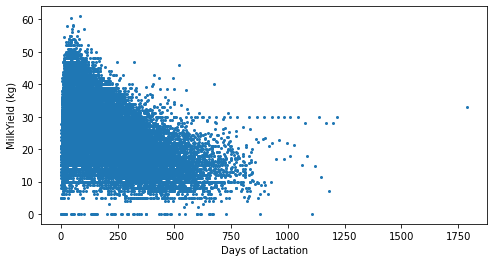

In [23]:
# Check the relationship between Days of Lactation & MilkYield
plt.figure(figsize=(8, 4))
plt.xlabel('Days of Lactation')
plt.ylabel('MilkYield (kg)')
plt.plot(df.DaysOfLactation, df.MilkYield, 'o', markersize=2)

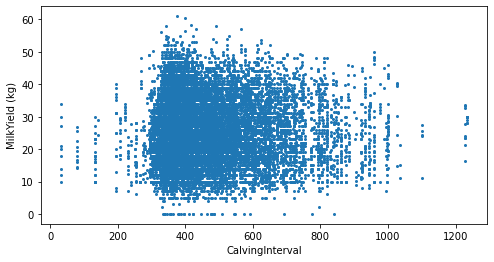

In [24]:
# Check the relationship between Calving Interval & MilkYield
plt.figure(figsize=(8, 4))
plt.xlabel('CalvingInterval')
plt.ylabel('MilkYield (kg)')
plt.plot(df.CalvingInterval, df.MilkYield, 'o', markersize=2)

In [25]:
# Days of lactation should be around 305, so those too large must be errors.
# Calving Interval should be around 365 days
# Fix by method below:
# 1. If the calving interval > 22 months (660d), then add a calving date in between;
#    >33 (990d), add 2; >44 (1320d), add 3...
# 2. If the last calving date is far from 2019.12.31, add a calving date every year until 2019
# 3. For the dry period, since we suggested that these cow should calf almost every year 
#    in order to continuously produce milk, then the dry period must not be too long, either.
#    As a result, we inputed the missing or too large dry period with the average of the normal ones.
#    If there is no normal one, than inpute the common dry period: 60.

newdf = df.copy()
def AddCalving(cow):
    filt = (newdf['CowNo'] == cow)
    list1 = list(set(newdf.loc[filt, 'LatestCalvingDate']))
    list2 = list(set(newdf.loc[filt, 'PreviousCalvingDate']))
    list3 = []
    for x in list2:
        if x not in list1 and str(x) != 'NaT':
            list3.append(x)
    caldates = list1 + list3
    caldates.sort()
    for i in range(len(caldates)-1):
        interval = (caldates[i+1] - caldates[i])/np.timedelta64(1, 'D')
        if 660 <= interval < 990:
            days = int(interval/2)
            caldates.append(caldates[i] + datetime.timedelta(days=days))
        elif 990 <= interval < 1320:
            days = int(interval/3)
            caldates.append(caldates[i] + datetime.timedelta(days=days))
            caldates.append(caldates[i] + datetime.timedelta(days=days*2))
        elif 1320 <= interval < 1650:
            days = int(interval/4)
            caldates.append(caldates[i] + datetime.timedelta(days=days))
            caldates.append(caldates[i] + datetime.timedelta(days=days*2)) 
            caldates.append(caldates[i] + datetime.timedelta(days=days*3))
    caldates.sort()
    x = caldates[-1]
    while (pd.to_datetime('2020-01-01') - x) > datetime.timedelta(days=365):
        caldates.append(caldates[-1] + datetime.timedelta(days=365))
        x = caldates[-1]
    caldates.sort()
    parlist = list(set(newdf.loc[filt, 'Parity']))
    parlist.sort()
    start_par = parlist[0]
    pars = []
    pars.append(start_par)
    for i in range(len(caldates)-1):
        pars.append(start_par+i+1)
    if pars[0] == 1:
        if len(list3) == 0:
            for i in range(len(caldates)):
                if i == 0:
                    fix.fir(newdf, cow, i+1, caldates[i], caldates[i+1])
                elif i == len(caldates)-1:
                    fix.last(newdf, cow, i+1, caldates[i-1], caldates[i])
                else:
                    fix.mid(newdf, cow, i+1, caldates[i-1], caldates[i], caldates[i+1])
        else:
            for i in range(len(caldates)):
                if i == 0:
                    fix.fir(newdf, cow, i+1, caldates[i], caldates[i+1])
                elif i == len(caldates)-1:
                    fix.last(newdf, cow, i, caldates[i-1], caldates[i])
                else:
                    fix.mid(newdf, cow, i, caldates[i-1], caldates[i], caldate[i+1])
    else:
        par1 = pars[0]
        if len(list3) == 0:
            for i in range(len(caldates)):
                j = i + par1
                if i == 0:
                    fix.fir(newdf, cow, j, caldates[i], caldates[i+1])
                elif i == len(caldates)-1:
                    fix.last(newdf, cow, j, caldates[i-1], caldates[i])
                else:
                    fix.mid(newdf, cow, j, caldates[i-1], caldates[i], caldates[i+1])
        else:
            for i in range(len(caldates)):
                j = par1 + i - 1
                if i == 0:
                    continue
                elif i == len(caldates)-1:
                    fix.last(newdf, cow, j, caldates[i-1], caldates[i])
                else:
                    fix.mid(newdf, cow, j, caldates[i-1], caldates[i], caldates[i+1])    
    drylist = []
    indexlist = newdf.loc[filt].index
    for i in indexlist:
        if newdf.loc[i, 'DryPeriod'] <100 and pd.isnull(newdf.loc[i, 'DryPeriod'])==False:
            drylist.append(newdf.loc[i, 'DryPeriod'])
    if len(drylist) > 0:
        dryaverage = int(sum(drylist)/len(drylist))
    else:
        dryaverage = 60
    for i in indexlist:
        if newdf.loc[i,'Parity'] == 1:
            newdf.loc[i,'DryPeriod'] = np.nan
        elif pd.isnull(newdf.loc[i,'DryPeriod']) == True or newdf.loc[i,'DryPeriod'] > 100:
            newdf.loc[i,'DryPeriod'] = dryaverage

filt = (newdf['DaysOfLactation'] > 600)
cowlist = list(set(newdf.loc[filt, 'CowNo']))
print(cowlist)
for x in cowlist:
    AddCalving(x)

[3051521, 98122753, 98122755, 1123334, 3051527, 3051528, 3051531, 3128845, 1123342, 3051535, 1123351, 3051548, 3051557, 10837547, 3051564, 3051570, 3125308, 1123388, 94183486, 10837567, 94183489, 1123396, 3051592, 3125322, 3125340, 3125343, 96121452, 3125357, 2122351, 96051829, 2122358, 2122364, 96051844, 2122378, 3125387, 3125388, 96051853, 2122383, 96185489, 2122387, 96123541, 3183614, 97126049, 96123553, 98186917, 98186928, 2127032, 2127034, 2127038, 2122431, 1181887, 1181889, 1051842, 94126787, 1181892, 99051719, 99051722, 99051723, 1051854, 1051855, 1051856, 2123481, 99051738, 2123486, 2127071, 99051746, 97127651, 99051751, 122602, 99051755, 122603, 99051757, 122614, 99051771, 122622, 122625, 99127554, 122630, 99127562, 122636, 87121678, 87121680, 122641, 122644, 99127572, 99127573, 122647, 99127575, 4181783, 97124122, 122656, 4181792, 122658, 97051428, 99127591, 97051439, 98091824, 97124144, 98091826, 97051444, 93053241, 97051454, 97051461, 97124169, 97124171, 97051468, 97051469,

In [26]:
# Fix columns: 'Calving Interval' & 'IfFirstCalving' & 'CalvingSeason'
newdf = newdf.drop(columns=['CalvingInterval','IfFirstCalving','CalvingSeason'])
newdf['CalvingInterval'] = (newdf['LatestCalvingDate'] - newdf['PreviousCalvingDate']).astype('timedelta64[D]')
newdf['IfFirstCalving'] = np.nan
for i in range(len(newdf['Parity'])):
    if pd.isnull(newdf.loc[i, 'Parity']) == 1:
        newdf.loc[i, 'IfFirstCalving']=0
    else:
        newdf.loc[i, 'IfFirstCalving']=1
newdf['CalvingSeason'] = ''
for i in range(len(newdf['LatestCalvingDate'])):
    month = int(newdf.loc[i, 'LatestCalvingDate'].month)
    if month in spring:
        newdf.loc[i, 'CalvingSeason'] = 'Spring'
    elif month in summer:
        newdf.loc[i, 'CalvingSeason'] = 'Summer'
    elif month in autumn:
        newdf.loc[i, 'CalvingSeason'] = 'Autumn'
    elif month in winter:
        newdf.loc[i, 'CalvingSeason'] = 'Winter'

# Fix DaysOfLactation
newdf = newdf.drop(columns=['DaysOfLactation'])
newdf['DaysOfLactation'] = (newdf['SampleDate'] - newdf['LatestCalvingDate']).astype('timedelta64[D]')

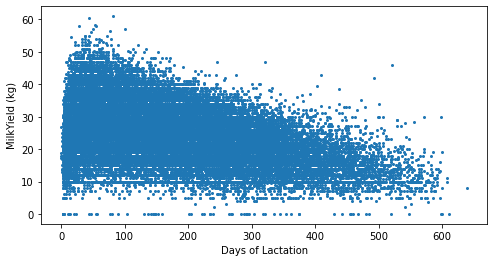

In [27]:
# Check the relationship between Days of Lactation & MilkYield again
plt.figure(figsize=(8, 4))
plt.xlabel('Days of Lactation')
plt.ylabel('MilkYield (kg)')
plt.plot(newdf.DaysOfLactation, newdf.MilkYield, 'o', markersize=2)

In [28]:
# Add 'HardnessOfCalving'
cols = ['CowNo', 'CalvingDate','HardnessOfCalving']
birth3 = birth2[cols].copy()
birth3['CalvingDate'] = pd.to_datetime(birth3['CalvingDate'])
birth3.rename(columns={'CalvingDate':'LatestCalvingDate'}, inplace=True)
df = pd.merge(newdf, birth3, on=['CowNo', 'LatestCalvingDate'], how='left')

In [29]:
print(spec.info())
print(spec.SituationType.unique())
print(spec.SituationCode.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CowNo          4362 non-null   int64 
 1   SituationType  4362 non-null   object
 2   SituationCode  3749 non-null   object
 3   SituationDate  4362 non-null   object
 4   Remarks        1197 non-null   object
 5   RecordingDate  3104 non-null   object
 6   FarmCode       4362 non-null   object
dtypes: int64(1), object(6)
memory usage: 238.7+ KB
None
['N' 'C' 'D' 'n' '1' '2' 'c']
[nan 'C' 'D' '20' '30' '32' '81' 'H5' '0' '74' '52' '31' '3' '12' '29' '5'
 '57' '42' '54' '50' '27' '38' '46' '39' '9H' '53' '40' '56' '2' '25' '11'
 '21' '26' '36' '43' 'C02' '1' '62' '55' '41' '24' '10' '47' '92' '48'
 '14' '61' '51' '80' '45' '60' '13' '4' '28' '18' '22']


In [30]:
# SituationCode describes the reason that caused the SituationType. If there were above 2 reasons,
# then there will be no SituationCode written. In this case, SituationType itself is filled.
# Report data starts at 2013, so we don't need the information that was too early.
spec1 = spec.copy()
spec1 = spec1.drop(['Remarks', 'RecordingDate'], axis=1)
spec1['SituationDate'] = pd.to_datetime(spec1['SituationDate'])
spec1 = spec1.drop(spec1[spec1.SituationDate < pd.to_datetime('2012-12-01')].index)
spec1['SituationType'] = spec1['SituationType'].replace({'n':'N', 'c':'C'})
for i in spec1.index:
    if pd.isnull(spec1.loc[i,'SituationCode']) == True:
        spec1.loc[i,'SituationCode'] = spec1.loc[i,'SituationType']
print(spec1.info())
print(spec1.SituationType.unique())
print(spec1.SituationCode.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2636 entries, 1497 to 4361
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CowNo          2636 non-null   int64         
 1   SituationType  2636 non-null   object        
 2   SituationCode  2636 non-null   object        
 3   SituationDate  2636 non-null   datetime64[ns]
 4   FarmCode       2636 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 203.6+ KB
None
['C' 'N' 'D']
['1' '40' 'N' '30' '42' '2' '31' '11' '41' '0' '27' '26' '12' '20' '50'
 '74' '61' '51' '80' '52' '3' '55' '45' '62' '81' '60' 'C' '43' '29' '5'
 '39' '21' '53' '56' '13' '10' '24' '32' '4' '54' '48' 'D' '28' '92' '18'
 '22']


In [31]:
# Add 'SituationType'
# Don't add 'SituationCode' because there are too many types, and after OneHotEncoding,
# there will be many columns with lots of zeros.
df['SituationType_C'] = np.nan
df['SituationType_D'] = np.nan
df['SituationType_N'] = np.nan
for x in list(df['CowNo'].unique()):
    filt = (df['CowNo']==x)
    df_cow = df[filt]
    filt = (spec1['CowNo']==x)
    spec_cow = spec1[filt]
    for i in df_cow.index:
        for j in spec_cow.index:
            if spec1.loc[j,'SituationDate']-datetime.timedelta(days=1) <= df.loc[i,'SampleDate'] <= spec1.loc[j,'SituationDate']+datetime.timedelta(days=30):
                if spec1.loc[j,'SituationType'] == 'C':
                    df.loc[i,'SituationType_C'] = int(1)
                if spec1.loc[j,'SituationType'] == 'D':
                    df.loc[i,'SituationType_D'] = int(1)
                if spec1.loc[j,'SituationType'] == 'N':
                    df.loc[i,'SituationType_N'] = int(1)
df['SituationType_C'] = df['SituationType_C'].fillna(int(0))
df['SituationType_D'] = df['SituationType_D'].fillna(int(0))
df['SituationType_N'] = df['SituationType_N'].fillna(int(0))

In [32]:
# Add 'AverageYield' to represent the productivity of each cow
df['AverageYield'] = np.nan
for x in list(df['CowNo'].unique()):
    filt = (df['CowNo']==x)
    df_cow = df[filt]
    yieldlist = [x for x in df_cow['MilkYield'] if x != 0 and pd.isnull(x)==False]
    if len(yieldlist) != 0:
        aver = sum(yieldlist)/len(yieldlist)
        for i in df_cow.index:
            df.loc[i,'AverageYield'] = aver
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37516 entries, 0 to 37515
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   37516 non-null  int64         
 1   Year                 37516 non-null  int64         
 2   Month                37516 non-null  int64         
 3   FarmCode             37516 non-null  object        
 4   CowNo                37516 non-null  int64         
 5   FatherSemenNo        36640 non-null  object        
 6   MotherNo             33932 non-null  object        
 7   BirthDate            37516 non-null  datetime64[ns]
 8   Parity               37516 non-null  int64         
 9   MilkYield            33253 non-null  float64       
 10  LatestCalvingDate    37516 non-null  datetime64[ns]
 11  SampleDate           37516 non-null  datetime64[ns]
 12  AgeInMonths          37516 non-null  int64         
 13  TestingDate          37516 non-

In [33]:
# Save the final dataframe
df.to_csv('/Users/Guanguan/Desktop/ML/data/FINAL.csv', index=False)

In [34]:
# Select columns that will be used for training (Dates, Cow or Semen numbers, and year are not selected)
cols = ['Month','FarmCode','Parity','AgeInMonths','NumberOfBreeding','MilkingSeason','BirthSeason',
        'CalvingSeason','Temperature','RH','THI','HeatStress','DryPeriod','CalvingInterval',
        'IfFirstCalving','DaysOfLactation','HardnessOfCalving','SituationType_C','SituationType_D',
        'SituationType_N','AverageYield','MilkYield']
total_df = df[cols].copy()
total_df = pd.get_dummies(total_df)

In [35]:
# Correlation test
total_corr = total_df.corr()
high_corr = list(total_corr.index[abs(total_corr['MilkYield'])>=0.4])
print(high_corr)

['DaysOfLactation', 'AverageYield', 'MilkYield']


In [36]:
# Seperate train and test dataset
train_df = total_df[total_df['MilkYield'].notnull()]
test_df = total_df[total_df['MilkYield'].isnull()]
test_df = test_df.drop(['MilkYield'], axis=1)

In [37]:
# Imputation: train_df
# DryPeriod
dry_list = [x for x in train_df['DryPeriod'] if x != 0 and pd.isnull(x)==False]
dry_mean = sum(dry_list)/len(dry_list)
for i in train_df.index:
    if pd.isnull(train_df.loc[i,'DryPeriod'])==True:
        if train_df.loc[i,'Parity']==1:
            train_df.loc[i,'DryPeriod']=0
        else:
            train_df.loc[i,'DryPeriod']=dry_mean

# CalvingInterval     
ci_list = [x for x in train_df['CalvingInterval'] if x != 0 and pd.isnull(x)==False]
ci_mean = sum(ci_list)/len(ci_list)
for i in train_df.index:
    if pd.isnull(train_df.loc[i,'CalvingInterval'])==True:
        if train_df.loc[i,'Parity']==1:
            train_df.loc[i,'CalvingInterval']=0
        else:
            train_df.loc[i,'CalvingInterval']=ci_mean

# HardnessOfCalving, AverageYield
hoc_list = [x for x in train_df['HardnessOfCalving'] if x != 0 and pd.isnull(x)==False]
hoc_mean = sum(hoc_list)/len(hoc_list)
ay_list = [x for x in train_df['AverageYield'] if x != 0 and pd.isnull(x)==False]
ay_mean = sum(ay_list)/len(ay_list)
for i in train_df.index:
    if pd.isnull(train_df.loc[i,'HardnessOfCalving'])==True:
        train_df.loc[i,'HardnessOfCalving'] = hoc_mean
    if pd.isnull(train_df.loc[i,'AverageYield'])==True:
        train_df.loc[i,'AverageYield'] = ay_mean

# Imputation: test_df
# DryPeriod
dry_list = [x for x in test_df['DryPeriod'] if x != 0 and pd.isnull(x)==False]
dry_mean = sum(dry_list)/len(dry_list)
for i in test_df.index:
    if pd.isnull(test_df.loc[i,'DryPeriod'])==True:
        if test_df.loc[i,'Parity']==1:
            test_df.loc[i,'DryPeriod']=0
        else:
            test_df.loc[i,'DryPeriod']=dry_mean

# CalvingInterval     
ci_list = [x for x in test_df['CalvingInterval'] if x != 0 and pd.isnull(x)==False]
ci_mean = sum(ci_list)/len(ci_list)
for i in test_df.index:
    if pd.isnull(test_df.loc[i,'CalvingInterval'])==True:
        if test_df.loc[i,'Parity']==1:
            test_df.loc[i,'CalvingInterval']=0
        else:
            test_df.loc[i,'CalvingInterval']=ci_mean

# HardnessOfCalving, AverageYield
hoc_list = [x for x in test_df['HardnessOfCalving'] if x != 0 and pd.isnull(x)==False]
hoc_mean = sum(hoc_list)/len(hoc_list)
ay_list = [x for x in test_df['AverageYield'] if x != 0 and pd.isnull(x)==False]
ay_mean = sum(ay_list)/len(ay_list)
for i in test_df.index:
    if pd.isnull(test_df.loc[i,'HardnessOfCalving'])==True:
        test_df.loc[i,'HardnessOfCalving'] = hoc_mean
    if pd.isnull(test_df.loc[i,'AverageYield'])==True:
        test_df.loc[i,'AverageYield'] = ay_mean

/Users/Guanguan/opt/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [38]:
# Final checking, and getting start to build prediction model
print(train_df.info())
print(test_df.info())
train_df.to_csv('/Users/Guanguan/Desktop/ML/data/FINAL_train.csv', index=False)
test_df.to_csv('/Users/Guanguan/Desktop/ML/data/FINAL_test.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33253 entries, 0 to 37515
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 33253 non-null  int64  
 1   Parity                33253 non-null  int64  
 2   AgeInMonths           33253 non-null  int64  
 3   NumberOfBreeding      33253 non-null  int64  
 4   Temperature           33253 non-null  float64
 5   RH                    33253 non-null  float64
 6   THI                   33253 non-null  float64
 7   HeatStress            33253 non-null  int64  
 8   DryPeriod             33253 non-null  float64
 9   CalvingInterval       33253 non-null  float64
 10  IfFirstCalving        33253 non-null  float64
 11  DaysOfLactation       33253 non-null  float64
 12  HardnessOfCalving     33253 non-null  float64
 13  SituationType_C       33253 non-null  float64
 14  SituationType_D       33253 non-null  float64
 15  SituationType_N    

In [39]:
# Divide the training dataset into 2 part, train and test (8:2)
# Train for training the model and test to check the accuracy of the model.
X = train_df.drop(['MilkYield'], axis=1)
y = train_df['MilkYield']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print(X_train.shape)

(26602, 32)


In [40]:
# Define a function for GridSearchCV (to tune the hyperparameters)
def Grid(model, grid_params, train_features, train_labels):
    grid = GridSearchCV(model, grid_params, scoring='neg_root_mean_squared_error', cv=5, verbose=2, n_jobs=-1, refit=True)
    grid.fit(train_features, train_labels)
    print('Best parameters:', grid.best_params_)
    print('Best score:', grid.best_score_, '\n')
    return grid

In [73]:
# Define a function for evaluating the model (to show average error, accuracy, RMSE, r2, and correlation coefficient)
# For the accuracy, ignore milk yield of zeros, or else accuracy will be negative infinity
def evaluate(model, test_features, test_labels):
    preds = model.predict(test_features)
    rmse = sqrt(mean_squared_error(test_labels, preds))
    r2 = r2_score(test_labels, preds)
    errors = abs(preds - test_labels)
    ignore_zero = test_labels.copy()
    ignore_zero[ignore_zero == 0] = np.nan
    mape = 100 * np.nanmean(errors / ignore_zero)
    accuracy = 100 - mape
    preds_df = pd.DataFrame({'Actual_values':test_labels, 
                             'Prediction_values':preds})
    corr_df = preds_df.corr(method='pearson')
    corr = corr_df.loc['Actual_values','Prediction_values']
    print('Model Performance')
    print('Average Error: {:0.4f} kg'.format(np.mean(errors)))
    print('Accuracy: {:0.2f}%'.format(accuracy))
    print('RMSE = {:0.4f}'.format(rmse))
    print('r2 = {:0.4f}'.format(r2))
    print('Correlation Coefficient = {:0.4f}'.format(corr))
    return rmse

In [109]:
# Base Random Forest Model
base_rf = RandomForestRegressor(random_state=42)
base_rf.fit(X_train, y_train)
base_rf_rmse = evaluate(base_rf, X_test, y_test)

Model Performance
Average Error: 3.6499 kg
Accuracy: 81.59%
RMSE = 4.9275
r2 = 0.6823
Correlation Coefficient = 0.8261


In [111]:
# Use RandomizedSearchCV to test 100 different combination of the hyperparameters,
# in order to decide the starting point that is highly possible to be close to the best hyperparameter combinaion.
start = datetime.datetime.now()

#
n_estimators = [int(x) for x in range(200, 2001, 200)]
max_features = [1.0, 'sqrt']
max_depth = [int(x) for x in range(10, 101, 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# There are 10 * 2 * 11 * 3 * 3 * 2 = 3960 settings in total
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, scoring='neg_root_mean_squared_error', random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print('\n', rf_random.best_params_)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [1.0, 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits

 {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}

Execution time: 4:41:44.802439


In [116]:
# rf_random model evaluation
params = {'n_estimators': 800,
          'min_samples_split': 2,
          'min_samples_leaf': 1,
          'max_features': 'sqrt',
          'max_depth': 70,
          'bootstrap': False}
rf_random = RandomForestRegressor(**params, random_state=42)
rf_random.fit(X_train, y_train)
rf_random_rmse = evaluate(rf_random, X_test, y_test)

Model Performance
Average Error: 3.6066 kg
Accuracy: 81.70%
RMSE = 4.8500
r2 = 0.6923
Correlation Coefficient = 0.8335


In [124]:
# Tune the hyperparameters based on the best result from random search with GridSearchCV
start = datetime.datetime.now()

#
model = RandomForestRegressor(random_state=42)
grid_params = {'n_estimators': [700, 800, 900],
               'max_features': ['sqrt'],
               'max_depth': [60, 70, 80],
               'min_samples_split': [2, 3, 4],
               'min_samples_leaf': [1, 2],
               'bootstrap': [False]}
grid = Grid(model, grid_params, X_train, y_train)
model_rmse = evaluate(grid, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'bootstrap': False, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 800}
Best score: -5.086451421130356 

Model Performance
Average Error: 3.6032 kg
Accuracy: 81.70%
RMSE = 4.8437
r2 = 0.6931
Correlation Coefficient = 0.8342

Execution time: 0:42:51.774416


In [125]:
# Predict test data with the best hyperparameters and generate the results into a csv file
params = {'bootstrap': False,
          'max_depth': 60,
          'max_features': 'sqrt',
          'min_samples_leaf': 1,
          'min_samples_split': 3,
          'n_estimators': 800}
rf_model = RandomForestRegressor(**params, random_state=42)
rf_model.fit(X, y)
prediction = rf_model.predict(test_df)
output = pd.DataFrame({'ID': submission.ID,
                       '1': prediction})
output['ID']=output['ID'].astype('int')
output.to_csv('/Users/Guanguan/Desktop/ML/Results/result20230330_rf.csv', index=False)

Model Performance
Average Error: 3.6340 kg
Accuracy: 81.73%
RMSE = 4.8773
r2 = 0.6888
Correlation Coefficient = 0.8300


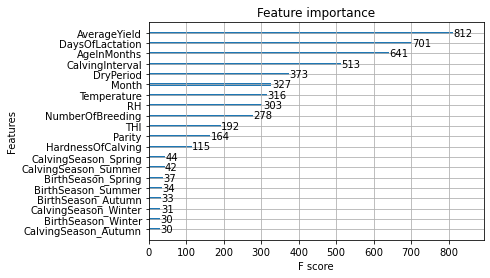

In [127]:
# Base XGBoost
base_xgb = XGBRegressor(seed=42)
base_xgb.fit(X_train, y_train)
base_xgb_rmse = evaluate(base_xgb, X_test, y_test)
plot_importance(base_xgb, max_num_features=20)
plt.show()

In [128]:
# Use RandomizedSearchCV to test 100 different combination of the hyperparameters,
# in order to decide the starting point that is highly possible to be close to the best hyperparameter combinaion.
start = datetime.datetime.now()

#
learning_rate = [0.1, 0.2, 0.3]
n_estimators = [int(x) for x in range(200, 1001, 200)]
max_depth = [int(x) for x in range(3, 10, 2)]
min_child_weight = [int(x) for x in range(1, 6, 2)]
subsample = [x/10.0 for x in range(6, 11, 2)]
colsample_bytree = [x/10.0 for x in range(6, 11, 2)]
gamma = [x/10.0 for x in range(0, 5, 2)]

random_grid = {'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'gamma': gamma}
print(random_grid)

# There are 3 * 5 * 4 * 3 * 3 * 3 * 3 = 4860 settings in total
# Use the random grid to search for best hyperparameters
xgb = XGBRegressor(seed=42)
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 500, cv = 3, verbose=2, random_state=42, n_jobs = -1)
xgb_random.fit(X_train, y_train)
print('\n', xgb_random.best_params_)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

{'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [200, 400, 600, 800, 1000], 'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'gamma': [0.0, 0.2, 0.4]}
Fitting 3 folds for each of 500 candidates, totalling 1500 fits

 {'subsample': 1.0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.6}

Execution time: 3:58:04.898750


In [131]:
# xgb_random model evaluation
params = {'subsample': 1.0,
          'n_estimators': 800,
          'min_child_weight': 1,
          'max_depth': 7,
          'learning_rate': 0.1,
          'gamma': 0.4,
          'colsample_bytree': 0.6}
xgb_random = XGBRegressor(**params, seed=42)
xgb_random.fit(X_train, y_train)
xgb_random_rmse = evaluate(xgb_random, X_test, y_test)

Model Performance
Average Error: 3.4398 kg
Accuracy: 82.71%
RMSE = 4.6777
r2 = 0.7137
Correlation Coefficient = 0.8450


In [132]:
# Tune the hyperparameters based on the best result from random search
# First, tune max_depth, min_child_weight, subsample, colsample_bytree, and gamma with GridSearchCV
start = datetime.datetime.now()

#
model = XGBRegressor(seed=42)
grid_params = {'learning_rate': [0.1],
               'n_estimators': [800],
               'max_depth': [6, 7, 8],
               'min_child_weight': [1, 2, 3],
               'subsample': [0.9, 0.95, 1.0],
               'colsample_bytree': [0.5, 0.6, 0.7],
               'gamma': [0.3, 0.4, 0.5]}
grid = Grid(model, grid_params, X_train, y_train)
model_rmse = evaluate(grid, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 800, 'subsample': 0.95}
Best score: -4.845285942415478 

Model Performance
Average Error: 3.4176 kg
Accuracy: 82.82%
RMSE = 4.6457
r2 = 0.7176
Correlation Coefficient = 0.8473

Execution time: 5:29:14.908111


In [135]:
# Check the numbers smaller than the minimum number of min_child_weight and gamma of the previous tuning
start = datetime.datetime.now()

#
model = XGBRegressor(seed=42)
grid_params = {'learning_rate': [0.1],
               'n_estimators': [800],
               'max_depth': [7],
               'min_child_weight': [3, 4, 5],
               'subsample': [0.95],
               'colsample_bytree': [0.6],
               'gamma': [0.1, 0.2, 0.3]}
grid = Grid(model, grid_params, X_train, y_train)
model_rmse = evaluate(grid, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

# The best hyperparameters remain the same combination

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 800, 'subsample': 0.95}
Best score: -4.845285942415478 

Model Performance
Average Error: 3.4176 kg
Accuracy: 82.82%
RMSE = 4.6457
r2 = 0.7176
Correlation Coefficient = 0.8473

Execution time: 0:09:23.533278


In [46]:
# Tune reg_alpha
start = datetime.datetime.now()

#
model = XGBRegressor(seed=42)
grid_params = {'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100],
                'learning_rate': [0.1], 
                'n_estimators': [800],
                'max_depth': [7], 
                'min_child_weight': [3], 
                'subsample': [0.95], 
                'colsample_bytree': [0.6], 
                'gamma': [0.3]}
grid = Grid(model, grid_params, X_train, y_train)
model_rmse = evaluate(grid, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 800, 'reg_alpha': 0, 'subsample': 0.95}
Best score: -4.845285942415478 

Model Performance
Average Error: 3.4176 kg
Accuracy: 82.82%
RMSE = 4.6457
r2 = 0.7176
Correlation Coefficient = 0.8473

Execution time: 0:06:14.012697


In [45]:
# Tune learning_rate and n_estimators
start = datetime.datetime.now()

#
model = XGBRegressor(seed=42)
grid_params = {'reg_alpha':[0],
                'learning_rate': [0.01, 0.05, 0.1, 0.15], 
                'n_estimators': [600, 800, 1000, 1200, 1400, 1600],
                'max_depth': [7], 
                'min_child_weight': [3], 
                'subsample': [0.95], 
                'colsample_bytree': [0.6], 
                'gamma': [0.3]}
grid = Grid(model, grid_params, X_train, y_train)
model_rmse = evaluate(grid, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 1600, 'reg_alpha': 0, 'subsample': 0.95}
Best score: -4.827099474081419 

Model Performance
Average Error: 3.3694 kg
Accuracy: 83.06%
RMSE = 4.5984
r2 = 0.7234
Correlation Coefficient = 0.8506

Execution time: 1:09:52.448506


In [47]:
# Tune learning_rate and n_estimators based on previous results with smaller intervals
start = datetime.datetime.now()

#
model = XGBRegressor(seed=42)
grid_params = {'reg_alpha':[0],
                'learning_rate': [0.03, 0.05, 0.07], 
                'n_estimators': [1500, 1600, 1700, 1800, 1900, 2000],
                'max_depth': [7], 
                'min_child_weight': [3], 
                'subsample': [0.95], 
                'colsample_bytree': [0.6], 
                'gamma': [0.3]}
grid = Grid(model, grid_params, X_train, y_train)
model_rmse = evaluate(grid, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 2000, 'reg_alpha': 0, 'subsample': 0.95}
Best score: -4.818412117331308 

Model Performance
Average Error: 3.3511 kg
Accuracy: 83.16%
RMSE = 4.5866
r2 = 0.7248
Correlation Coefficient = 0.8515

Execution time: 2:10:46.146912


In [50]:
# The best n_estimators is the largest number of the preious tuning
# Check if the model performance can improve if increasing n_estimators
start = datetime.datetime.now()

#
model = XGBRegressor(seed=42)
grid_params = {'reg_alpha':[0],
                'learning_rate': [0.05], 
                'n_estimators': [2000, 2200, 2400, 2600, 2800, 3000, 4000, 5000],
                'max_depth': [7], 
                'min_child_weight': [3], 
                'subsample': [0.95], 
                'colsample_bytree': [0.6], 
                'gamma': [0.3]}
grid = Grid(model, grid_params, X_train, y_train)
model_rmse = evaluate(grid, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

# The results show that although the model has a higher training score, 
# the performance of predicting unseen data is worse
# The best hyperparameters are still the combination of the previous tuning

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 2400, 'reg_alpha': 0, 'subsample': 0.95}
Best score: -4.814451451627011 

Model Performance
Average Error: 3.3459 kg
Accuracy: 83.20%
RMSE = 4.5879
r2 = 0.7246
Correlation Coefficient = 0.8515

Execution time: 0:31:55.873385


Model Performance
Average Error: 3.3511 kg
Accuracy: 83.16%
RMSE = 4.5866
r2 = 0.7248
Correlation Coefficient = 0.8515


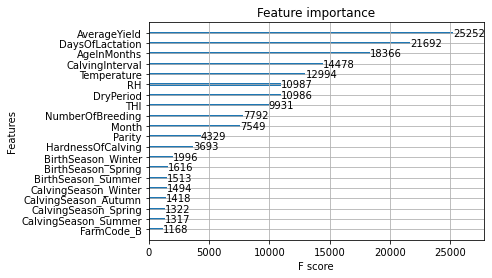

In [74]:
# Predict test data with the best hyperparameters and generate the results into a csv file
params = {'colsample_bytree': 0.6,
          'gamma': 0.3,
          'learning_rate': 0.05,
          'max_depth': 7,
          'min_child_weight': 3,
          'n_estimators': 2000,
          'reg_alpha': 0,
          'subsample': 0.95}
xgb_model = XGBRegressor(**params, seed=42)
xgb_model.fit(X_train, y_train)
xgb_model_rmse = evaluate(xgb_model, X_test, y_test)
plot_importance(xgb_model, max_num_features=20)
plt.show()

prediction = xgb_model.predict(test_df)
output = pd.DataFrame({'ID': submission.ID,
                       '1': prediction})
output['ID']=output['ID'].astype('int')
output.to_csv('/Users/Guanguan/Desktop/ML/Results/result20230406_xgb.csv', index=False)

In [64]:
# Divide the training data into train1 and valid for deep learning models
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=0)
print(X_train1.shape)

(21281, 32)


In [85]:
# Create another evaluation function because the prediction result is an numpy array in 2 dimensions instead of 1
# Use np.squeeze() to make it 1 dimension
def evaluate_dl(model, test_features, test_labels):
    preds = model.predict(test_features)
    preds = np.squeeze(preds)
    rmse = sqrt(mean_squared_error(test_labels, preds))
    r2 = r2_score(test_labels, preds)
    errors = abs(preds - test_labels)
    ignore_zero = test_labels.copy()
    ignore_zero[ignore_zero == 0] = np.nan
    mape = 100 * np.nanmean(errors / ignore_zero)
    accuracy = 100 - mape
    preds_df = pd.DataFrame({'Actual_values':test_labels, 
                             'Prediction_values':preds})
    corr_df = preds_df.corr(method='pearson')
    corr = corr_df.loc['Actual_values','Prediction_values']
    print('Model Performance')
    print('Average Error: {:0.4f} kg'.format(np.mean(errors)))
    print('Accuracy: {:0.2f}%'.format(accuracy))
    print('RMSE = {:0.4f}'.format(rmse))
    print('r2 = {:0.4f}'.format(r2))
    print('Correlation Coefficient = {:0.4f}'.format(corr))
    return rmse

Train on 21281 samples, validate on 5321 samples
Epoch 1/500
21281/21281 [==============================] - 1s 56us/sample - loss: 23.8762 - val_loss: 22.9178
Epoch 2/500
21281/21281 [==============================] - 0s 14us/sample - loss: 23.6837 - val_loss: 23.0124
Epoch 3/500
21281/21281 [==============================] - 0s 13us/sample - loss: 23.4328 - val_loss: 22.8143
Epoch 4/500
21281/21281 [==============================] - 0s 13us/sample - loss: 23.1157 - val_loss: 22.5752
Epoch 5/500
21281/21281 [==============================] - 0s 13us/sample - loss: 22.7256 - val_loss: 22.3454
Epoch 6/500
21281/21281 [==============================] - 0s 13us/sample - loss: 22.2720 - val_loss: 21.7490
Epoch 7/500
21281/21281 [==============================] - 0s 14us/sample - loss: 21.7402 - val_loss: 21.3656
Epoch 8/500
21281/21281 [==============================] - 0s 13us/sample - loss: 21.1442 - val_loss: 20.9378
Epoch 9/500
21281/21281 [==============================] - 0s 14us/samp

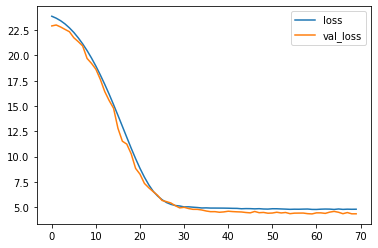

In [86]:
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[32]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
)

early_stopping = keras.callbacks.EarlyStopping(
patience=10,
min_delta=0.001,
restore_best_weights=True,
)

history= model.fit(
        X_train1, y_train1,
        validation_data=(X_valid, y_valid),
        batch_size=512,
        epochs=500,
        callbacks=[early_stopping])
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))
dl_rmse = evaluate_dl(model, X_test, y_test)

Train on 21281 samples, validate on 5321 samples
Epoch 1/500
21281/21281 [==============================] - 1s 62us/sample - loss: 23.8609 - val_loss: 23.7490
Epoch 2/500
21281/21281 [==============================] - 0s 13us/sample - loss: 23.6537 - val_loss: 23.3355
Epoch 3/500
21281/21281 [==============================] - 0s 13us/sample - loss: 23.4196 - val_loss: 23.1406
Epoch 4/500
21281/21281 [==============================] - 0s 13us/sample - loss: 23.1555 - val_loss: 22.6387
Epoch 5/500
21281/21281 [==============================] - 0s 13us/sample - loss: 22.8602 - val_loss: 22.2670
Epoch 6/500
21281/21281 [==============================] - 0s 13us/sample - loss: 22.5339 - val_loss: 21.9531
Epoch 7/500
21281/21281 [==============================] - 0s 13us/sample - loss: 22.1756 - val_loss: 21.8035
Epoch 8/500
21281/21281 [==============================] - 0s 13us/sample - loss: 21.7856 - val_loss: 21.0281
Epoch 9/500
21281/21281 [==============================] - 0s 13us/samp

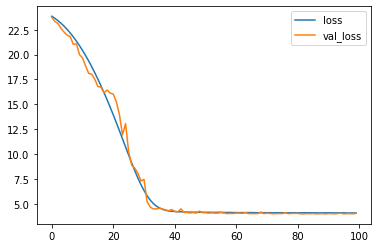

In [88]:
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[32]),
    layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(4, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
)

early_stopping = keras.callbacks.EarlyStopping(
patience=10,
min_delta=0.001,
restore_best_weights=True,
)

history= model.fit(
        X_train1, y_train1,
        validation_data=(X_valid, y_valid),
        batch_size=512,
        epochs=500,
        callbacks=[early_stopping],
    )
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))
dl_rmse = evaluate_dl(model, X_test, y_test)

Train on 21281 samples, validate on 5321 samples
Epoch 1/500
21281/21281 [==============================] - 0s 18us/sample - loss: 26.6225 - val_loss: 23.9205
Epoch 2/500
21281/21281 [==============================] - 0s 6us/sample - loss: 21.6593 - val_loss: 18.0159
Epoch 3/500
21281/21281 [==============================] - 0s 6us/sample - loss: 14.2894 - val_loss: 12.7194
Epoch 4/500
21281/21281 [==============================] - 0s 6us/sample - loss: 12.0732 - val_loss: 11.4160
Epoch 5/500
21281/21281 [==============================] - 0s 5us/sample - loss: 10.7959 - val_loss: 10.1538
Epoch 6/500
21281/21281 [==============================] - 0s 6us/sample - loss: 9.5527 - val_loss: 8.9669
Epoch 7/500
21281/21281 [==============================] - 0s 5us/sample - loss: 8.4361 - val_loss: 7.9190
Epoch 8/500
21281/21281 [==============================] - 0s 5us/sample - loss: 7.5021 - val_loss: 7.0523
Epoch 9/500
21281/21281 [==============================] - 0s 5us/sample - loss: 6.7

Epoch 75/500
21281/21281 [==============================] - 0s 6us/sample - loss: 4.2324 - val_loss: 4.1469
Epoch 76/500
21281/21281 [==============================] - 0s 6us/sample - loss: 4.2382 - val_loss: 4.1295
Epoch 77/500
21281/21281 [==============================] - 0s 5us/sample - loss: 4.2243 - val_loss: 4.1384
Epoch 78/500
21281/21281 [==============================] - 0s 5us/sample - loss: 4.2218 - val_loss: 4.1242
Epoch 79/500
21281/21281 [==============================] - 0s 5us/sample - loss: 4.2128 - val_loss: 4.1276
Epoch 80/500
21281/21281 [==============================] - 0s 5us/sample - loss: 4.2188 - val_loss: 4.1222
Epoch 81/500
21281/21281 [==============================] - 0s 5us/sample - loss: 4.2295 - val_loss: 4.1221
Epoch 82/500
21281/21281 [==============================] - 0s 5us/sample - loss: 4.2210 - val_loss: 4.1600
Epoch 83/500
21281/21281 [==============================] - 0s 5us/sample - loss: 4.2181 - val_loss: 4.1721
Epoch 84/500
21281/21281 [==

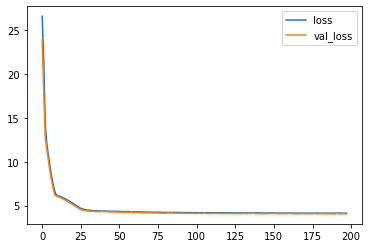

In [89]:
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[32]),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
)

early_stopping = keras.callbacks.EarlyStopping(
patience=10,
min_delta=0.001,
restore_best_weights=True,
)

history= model.fit(
        X_train1, y_train1,
        validation_data=(X_valid, y_valid),
        batch_size=512,
        epochs=500,
        callbacks=[early_stopping],
    )
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))
dl_rmse = evaluate_dl(model, X_test, y_test)

In [ ]:
# output = pd.DataFrame({'ID': submission.ID,
#                        '1': prediction})
# output['ID']=output['ID'].astype('int')
# output.to_csv('/Users/Guanguan/Desktop/ML/Results/result20230323.csv', index=False)